<h1>Group 37 Project Report: An Empirical Analysis of Pulsar Signalling <h1>

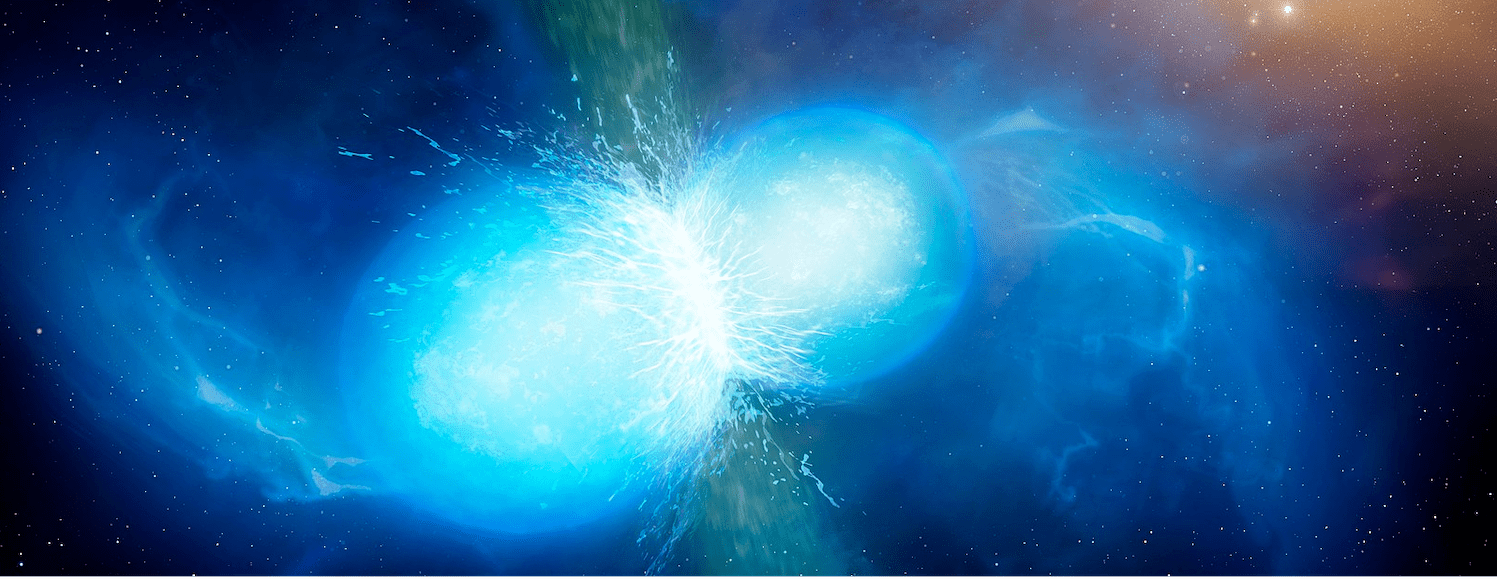

<font size="2"> <i>image attribution</i>: University of Warwick/Mark Garlick, CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons </font>

*Total Word Count: 582*

Pulsars are a rare type of neutron star that rotates while emitting electromagnetic radiation. When directed at the earth, these  emissions can be picked up by radio telescopes, producing radio waves of recognizable frequencies.
Unfortunately, however, these frequencies are difficult to separate from terrestrial radio interference, making it difficult for astronomers to detect veritable pulsars. <br>

To investigate this phenomenon statistically, our group posed the question: **"How accurate is KNN classification at differentiating pulsar emissions from interference?"** using a K-nearest neighbors (KNN) algorithm to differentiate pulsar from terrestrial emissions. <br>

This was done using the *HTRU2 Dataset* collected by Dr. Robert Lyon. <br>
This data frame has nine columns, including eight quantitative columns and one class column. The column names are shown below (Machine Learning Repository, n.d.): <br>

<ol>
  <li>Mean of the integrated profile</li>
  <li>Standard deviation of the integrated profile</li>
  <li>Excess kurtosis of the integrated profile</li>
  <li>Skewness of the integrated profile</li>
  <li>Mean of the DM-SNR curve</li>
  <li>Standard deviation of the DM-SNR curve</li>
  <li>Excess kurtosis of the DM-SNR curve</li>
  <li>Skewness of the DM-SNR curve</li>
  <li>Class</li>
</ol>

<h3>Methods & Results<h3>

First, we perform some bookkeeping - importing the necessary packages, before setting a *seed* of 3333 for reproducibility. <br>


In [2]:
#Done to remove warning messages from the proposal and improve readability
options(warn=-1)
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 4)
library(tidyverse)
library(tidymodels)
library(GGally)
set.seed(3333)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::

Next, we download the HTRU2 zip file from the dataset URL using *download.file()*, unzip using the *unz()* function, before loading our data frame with *read_csv()* load our data frame.

In [3]:
HTRU2_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"

download.file(HTRU2_url, destfile = "HTRU_2.zip") 

#Unz used here as the downloaded file in question is not a raw csv file - but a .zip file with a csv file inside
HTRU_df <- unz("HTRU_2.zip", "HTRU_2.csv") %>% 
    read_csv(col_names = c("Mean of the integrated profile",
                           "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile",
                           "Skewness of the integrated profile",
                           "Mean of the DM-SNR curve",
                           "Standard deviation of the DM-SNR curve",
                           "Excess kurtosis of the DM-SNR curve",
                           "Skewness of the DM-SNR curve",
                           "Class"))
HTRU_df

Parsed with column specification:
cols(
  `Mean of the integrated profile` = col_double(),
  `Standard deviation of the integrated profile` = col_double(),
  `Excess kurtosis of the integrated profile` = col_double(),
  `Skewness of the integrated profile` = col_double(),
  `Mean of the DM-SNR curve` = col_double(),
  `Standard deviation of the DM-SNR curve` = col_double(),
  `Excess kurtosis of the DM-SNR curve` = col_double(),
  `Skewness of the DM-SNR curve` = col_double(),
  Class = col_double()
)



Mean of the integrated profile,Standard deviation of the integrated profile,⋯,Skewness of the DM-SNR curve,Class
<dbl>,<dbl>,⋯,<dbl>,<dbl>
140.5625,55.68378,⋯,74.24222,0
102.5078,58.88243,⋯,127.39358,0
103.0156,39.34165,⋯,63.17191,0
⋮,⋮,⋱,⋮,⋮
119.3359,59.93594,⋯,4.595173,0
114.5078,53.90240,⋯,134.238910,0
57.0625,85.79734,⋯,1.429475,0


Although this dataset is already **tidy**,  three wrangling improvements are made:
<ol>
  <li>Spaces are removed from column names </li>
  <li>Class values (0 and 1) are replaced by "<b>Pulsar Star</b>" and "<b>Interference</b>" (as defined by metadata) </li>
  <li>The class column is converted to a factor datatype </li>
</ol>

In [4]:
colnames(HTRU_df) <- make.names(colnames(HTRU_df))

#the ifelse() function is used here to read the 0 or 1 class values, then exchange with "Pulsar Star" or "Interference" characters respectively
pulsar_df <- HTRU_df %>%
    mutate(Class = as.factor(ifelse(Class == 1, "Pulsar Star", "Interference")))

Then, split the data into training (75%) and testing (25%) datasets using the *initial_split()* function

In [5]:
pulsar_split <- initial_split(pulsar_df, prop = 0.75, strata = Class) 
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

Before diving into classification, we need to first perform some preliminary data analysis to determine the **class frequencies**, **mean predictor values**, and the **number of rows of missing data.**

**Number of Observations Per Class**

In [6]:
n_obs_df <- pulsar_training %>%
    group_by(Class) %>%
    summarize(Class.Frequency = n())

total_n <- n_obs_df %>%
    select(Class.Frequency) %>%
    colSums()

frequency_df <- mutate(n_obs_df, Percent.Class.Frequency = round((Class.Frequency/total_n)*100, digits = 0))

frequency_df

`summarise()` ungrouping output (override with `.groups` argument)



Class,Class.Frequency,Percent.Class.Frequency
<fct>,<int>,<dbl>
Interference,12183,91
Pulsar Star,1241,9


As can be seen in the table above, there is a large discrepancy between the number of **interference** values (91%) and the number of **pulsar star** values (9%). <br> As K nearest neighbors classification performs poorly under class imbalance, *upsampling* will thus be performed using the **themis** package - duplicating pulsar star observations to increase the 'weight' they hold to affect the classification of new observations

**Mean Predictor Values**

In [7]:
mean_df <- pulsar_training %>%
    select(-Class) %>%
    map_df(mean, na.rm  = TRUE)

mean_df

Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,⋯,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve
<dbl>,<dbl>,⋯,<dbl>,<dbl>
110.8804,46.47313,⋯,8.328325,105.6463


Considering the breadth in values across all variables, we'll need to *standardize* each to improve classification - setting the mean to 0 and standard deviation to 1 when creating our recipe. Additionally, as this dataset has been reviewed by human annotators there are no missing values present.

 With that out of the way, let's perform some introductory forward selection.

**Forward Selection**

In order to choose the variables that make the classifier the most accurate, here we use forward selection- iteratively building up a model by adding one predictor variable at a time (Campell et al., 2021). 

This process involves the following steps (Campell et al., 2021): <br>
1. Start with a model having no predictors 
2. Run the following 3 steps until you run out of predictors: 
   a. for each unused predictor, add it to the model to form a candidate model
   b. tune all of the candidate models
   c. update the model to be the candidate model with the highest cross-validation accuracy
3. select the model that provides the best trade-off between accuracy and simplicity 

In [22]:
p_cols <- colnames(pulsar_training %>% select(-Class))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = Class)

selected <- c()

for (i in 1:length(p_cols)) {
    
    accs <- list()
    models <- list()
    
    for (j in 1:length(p_cols)) {
        
        preds_new <- c(selected, p_cols[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
        pulsar_recipe <- recipe(as.formula(model_string), data = pulsar_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())
        
        acc <- workflow() %>%
                        add_recipe(pulsar_recipe) %>%
                        add_model(knn_spec) %>%
                        tune_grid(resamples = pulsar_vfold, grid = 10) %>%
                        collect_metrics() %>%
                        filter(.metric == "accuracy") %>%
                        summarize(mx = max(mean))
        
        acc <- acc$mx %>% unlist()
        
        accs[[j]] <- acc
        
        models[[j]] <- model_string        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
                    add_row(size = i, 
                            model_string = models[[jstar]], 
                            accuracy = accs[[jstar]])
    selected <- c(selected, p_cols[[jstar]])
    p_cols <- p_cols[-jstar]    
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Excess.kurtosis.of.the.integrated.profile,0.9772051
2,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve,0.9797378
3,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile,0.9797380
⋮,⋮,⋮
6,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile,0.9795145
7,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile+Skewness.of.the.DM.SNR.curve,0.9792165
8,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile+Skewness.of.the.DM.SNR.curve+Excess.kurtosis.of.the.DM.SNR.curve,0.9789186


By reviewing the change in accuracy values present in the table above, we view increases only for the first three predictors. Thus it seems the only variables with a positive influence upon the pulsar prediction are:
<ol>
  <li><b>Excess Kurtosis of the Integrated Profile </b></li>
  <li><b>Mean of the DM-SNR curve</b></li>
  <li><b>Mean of the Integrated Profile</b></li>
</ol>

Our training and testing data is constricted below to reflect these findings:

In [8]:
pulsar_training <- select(pulsar_training, "Mean.of.the.integrated.profile",
                                            "Excess.kurtosis.of.the.integrated.profile",
                                            "Mean.of.the.DM.SNR.curve",
                                            "Class")
pulsar_testing <- select(pulsar_testing, "Mean.of.the.integrated.profile",
                                            "Excess.kurtosis.of.the.integrated.profile",
                                            "Mean.of.the.DM.SNR.curve",
                                            "Class")
pulsar_training

Mean.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<fct>
103.01562,0.32332837,3.121237,Interference
136.75000,-0.06841464,3.642977,Interference
88.72656,0.60086608,1.178930,Interference
⋮,⋮,⋮,⋮
122.5547,0.1279781,16.409699,Interference
119.3359,0.1593631,21.430602,Interference
114.5078,0.2011614,1.946488,Interference


To better understand the relationships between the three predictors and pulsar class, we perform an introductory visualization below:

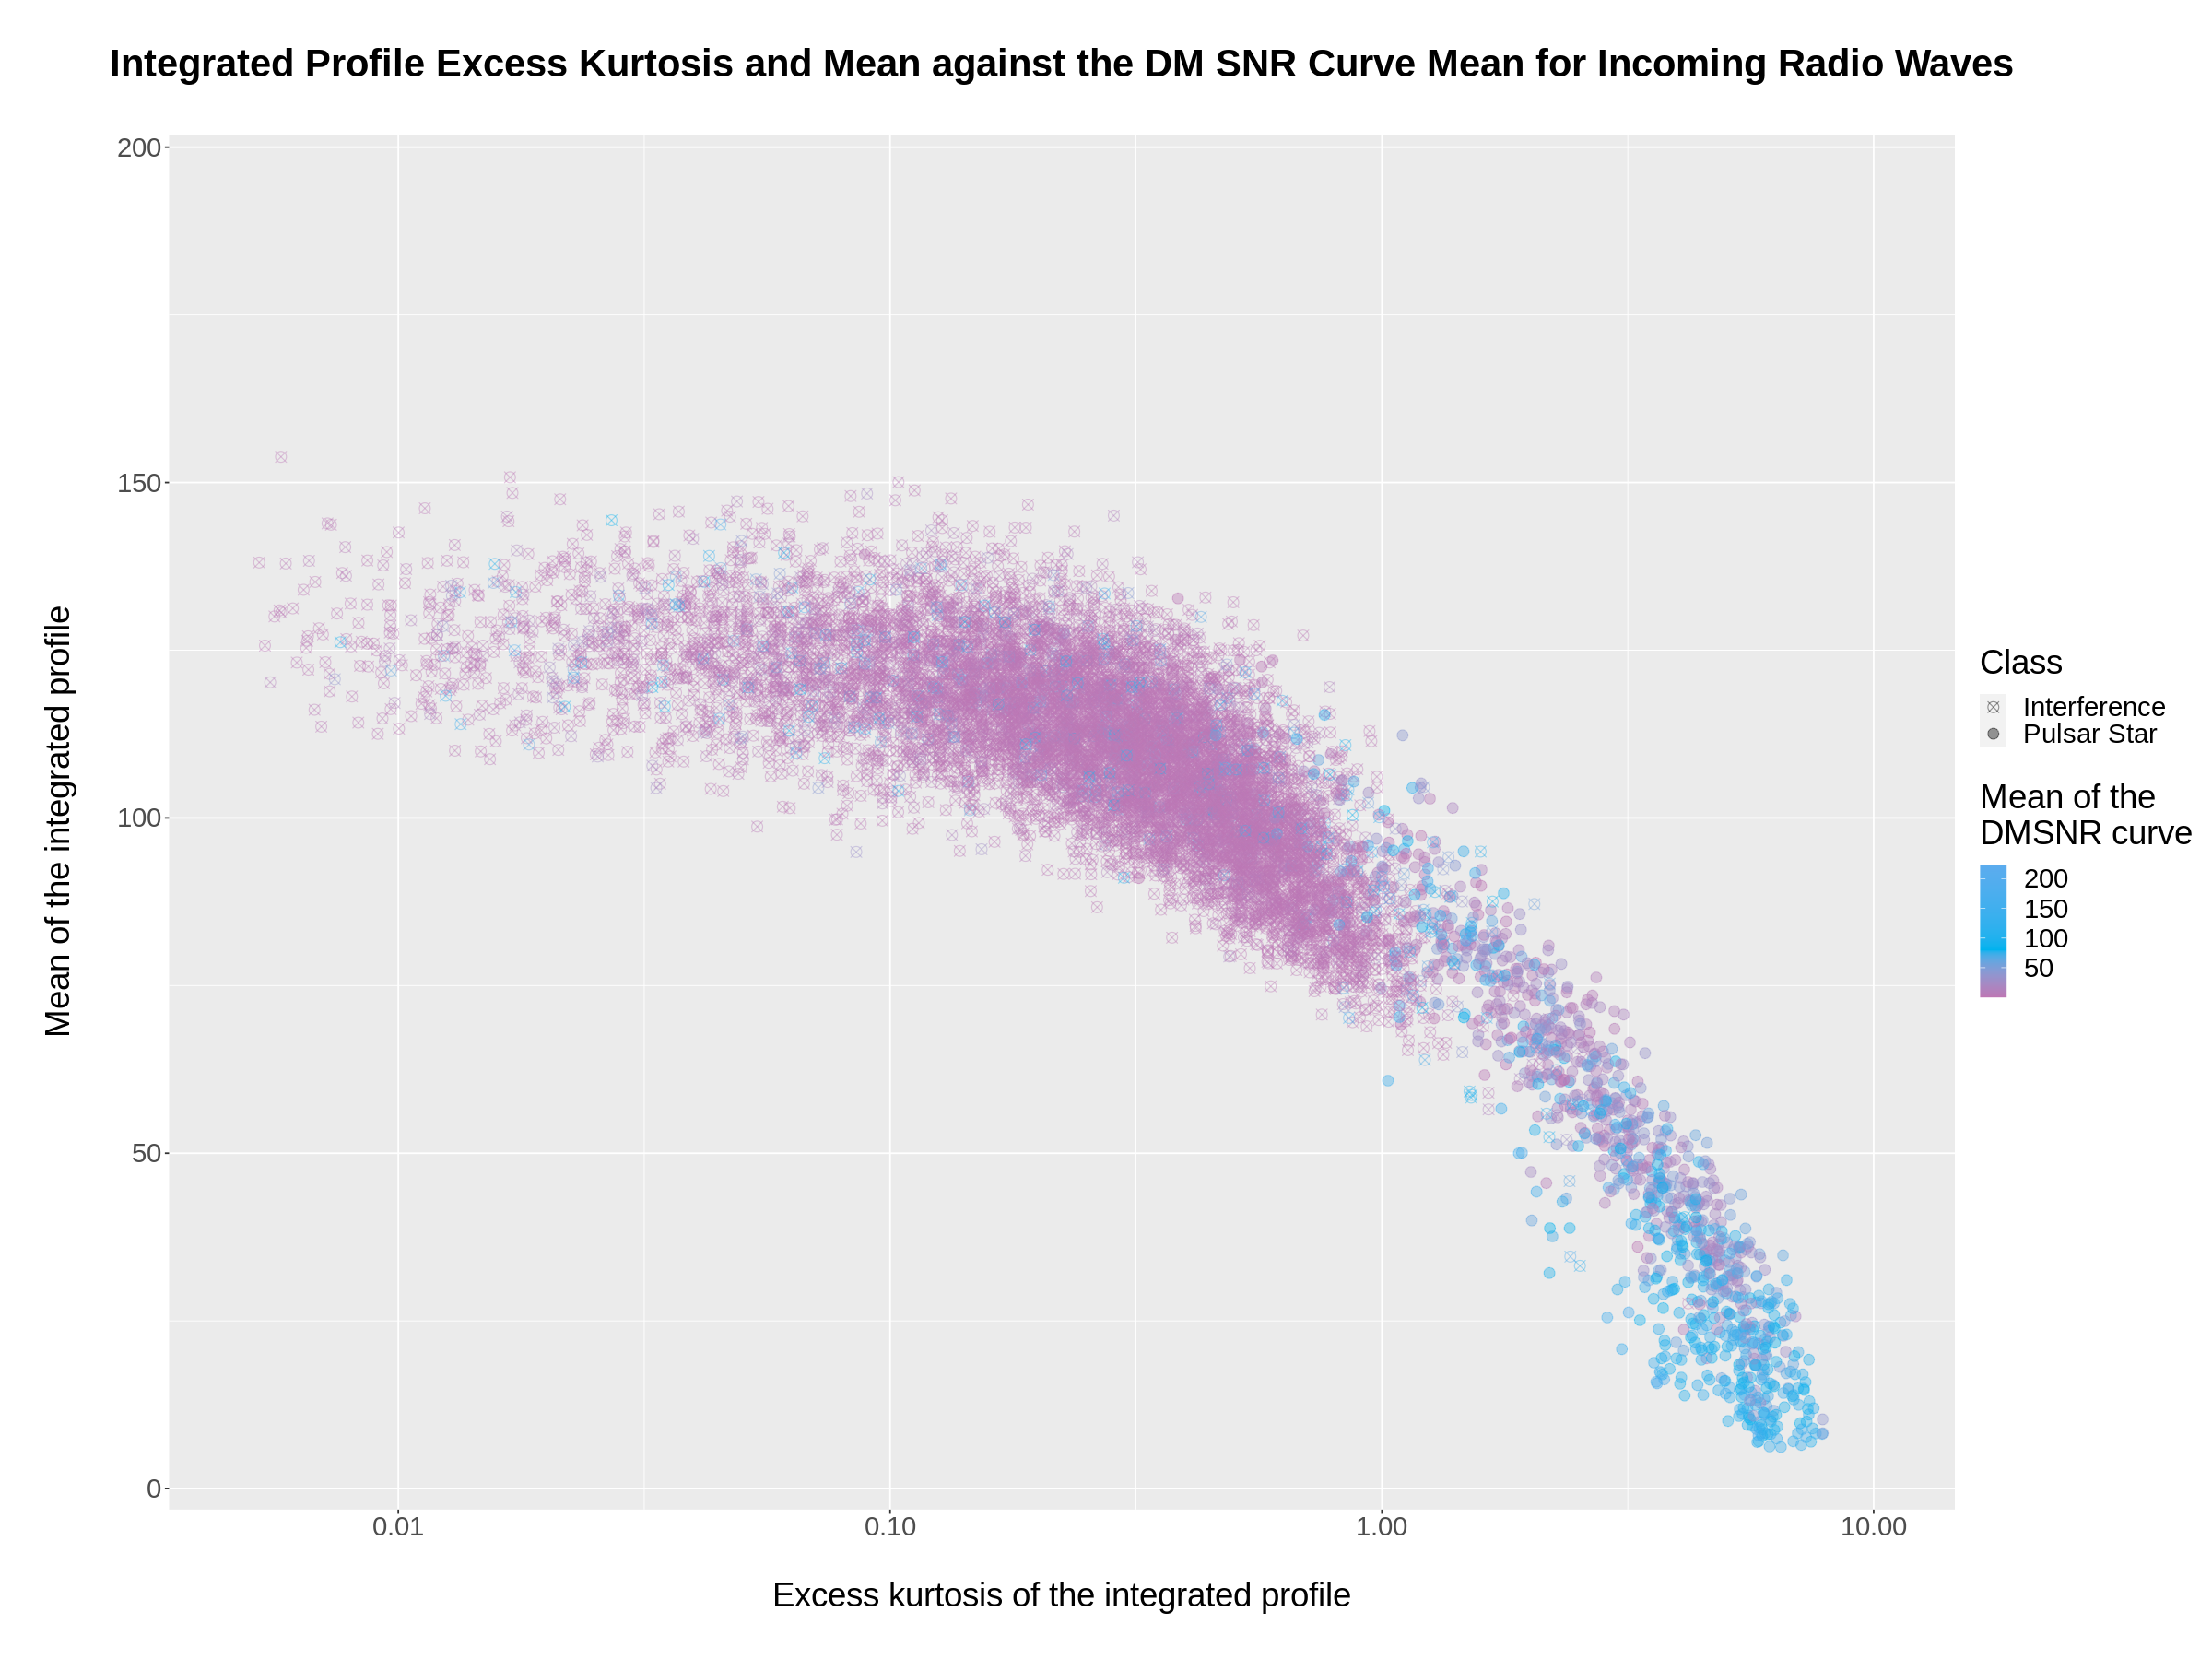

In [138]:
options(repr.plot.width = 20, repr.plot.height = 15)
pulsar_plot <- pulsar_training %>%
    ggplot(aes(x = Excess.kurtosis.of.the.integrated.profile, 
               y = Mean.of.the.integrated.profile, 
               colour = Mean.of.the.DM.SNR.curve,
               shape = Class)) +
        geom_point(alpha = 0.4, 
                   size = 3) +
        scale_shape_manual(values=c(13, 19)) +
        labs(x = "\nExcess kurtosis of the integrated profile\n", 
             y = "\nMean of the integrated profile\n", 
             color = "Mean of the\nDMSNR curve", 
             shape = "Class") +
        ggtitle("\nIntegrated Profile Excess Kurtosis and Mean against the DM SNR Curve Mean for Incoming Radio Waves\n") +
        theme(text = element_text(size = 22),
              plot.title = element_text(size = 25, 
                                        face="bold", 
                                        hjust = 0.5))+
        scale_x_log10(limits = c(0.005, 10)) +
        scale_color_gradient2(low = "deeppink2",
                              mid = "deepskyblue2",
                              high = "steelblue2", 
                              midpoint = 80)

pulsar_plot

### 

<h3>References<h3> 

Campbell, T., Lee, M., & Timbers, T. (2021). Data Science: A First Introduction. Retrieved November 28, 2021, from https://ubc-dsci.github.io/introduction-to-datascience/classification2.html#predictor-variable-selection

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple   filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Machine Learning Repository. (n.d.). HTRU2 Data Set. N.p.: University College London. Retrieved November 4, 2021, from https://archive.ics.uci.edu/ml/datasets/HTRU2

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443-2450.

Sagan, C. (1994). Pale Blue Dot: A Vision of the Human Future in Space. Random House.